##Sample project code using Team stats


In [1]:
import json
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import pandas as pd
import statsmodels.api as sm
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import statsmodels.api as sm
import pandas as pd

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Function to scrape team stats (simulated for this example)
def get_team_stats(team_id):
    if team_id == 1610612738:  # Boston Celtics
        return pd.DataFrame({
            'Team': ['Celtics'],
            'W': [9], 'L': [2], 'WIN%': [0.818],
            'PTS': [120.2], 'FG%': [47.7], '3P%': [35.5],
            'REB': [43.5], 'AST': [23.9], 'TOV': [13.5],
            'STL': [7.5], 'BLK': [6.5]
        })
    elif team_id == 1610612743:  # Denver Nuggets
        return pd.DataFrame({
            'Team': ['Nuggets'],
            'W': [4], 'L': [3], 'WIN%': [0.571],
            'PTS': [118.3], 'FG%': [48.4], '3P%': [38.1],
            'REB': [47.3], 'AST': [28.7], 'TOV': [14.3],
            'STL': [8.6], 'BLK': [5.0]
        })

# Get team stats
celtics_stats = get_team_stats(1610612738)
nuggets_stats = get_team_stats(1610612743)

# Combine stats
stats = pd.concat([celtics_stats, nuggets_stats])

# Select relevant features for prediction
features = ['WIN%', 'PTS', 'FG%', '3P%', 'REB', 'AST', 'TOV', 'STL', 'BLK']

# Normalize the features
scaler = MinMaxScaler()
stats[features] = scaler.fit_transform(stats[features])

# Define weights for each feature
weights = {
    'WIN%': 0.25, 'PTS': 0.2, 'FG%': 0.1, '3P%': 0.1,
    'REB': 0.1, 'AST': 0.1, 'TOV': -0.05, 'STL': 0.05, 'BLK': 0.05
}

# Calculate weighted scores
stats['Score'] = sum(stats[feat] * weight for feat, weight in weights.items())

# Predict winner
winner = stats.loc[stats['Score'].idxmax(), 'Team']
win_probability = stats['Score'].max() / stats['Score'].sum()

print(f"Predicted winner: {winner}")
print(f"Win probability: {win_probability:.2%}")

# Compare key stats
print("\nKey Stats Comparison:")
for feat in features:
    celtics_val = celtics_stats[feat].values[0]
    nuggets_val = nuggets_stats[feat].values[0]
    print(f"{feat}: Celtics {celtics_val:.2f} vs Nuggets {nuggets_val:.2f}")

# Insights
print("\nInsights:")
for feat in features:
    diff = celtics_stats[feat].values[0] - nuggets_stats[feat].values[0]
    if abs(diff) > 0.05:  # Threshold for significant difference
        better_team = "Celtics" if diff > 0 else "Nuggets"
        print(f"- {better_team} have a significant advantage in {feat}")

Predicted winner: 0    Celtics
0    Nuggets
Name: Team, dtype: object
Win probability: 55.56%

Key Stats Comparison:
WIN%: Celtics 0.82 vs Nuggets 0.57
PTS: Celtics 120.20 vs Nuggets 118.30
FG%: Celtics 47.70 vs Nuggets 48.40
3P%: Celtics 35.50 vs Nuggets 38.10
REB: Celtics 43.50 vs Nuggets 47.30
AST: Celtics 23.90 vs Nuggets 28.70
TOV: Celtics 13.50 vs Nuggets 14.30
STL: Celtics 7.50 vs Nuggets 8.60
BLK: Celtics 6.50 vs Nuggets 5.00

Insights:
- Celtics have a significant advantage in WIN%
- Celtics have a significant advantage in PTS
- Nuggets have a significant advantage in FG%
- Nuggets have a significant advantage in 3P%
- Nuggets have a significant advantage in REB
- Nuggets have a significant advantage in AST
- Nuggets have a significant advantage in TOV
- Nuggets have a significant advantage in STL
- Celtics have a significant advantage in BLK


**STEP 1: DATA COLLECTION**

---



In [149]:
#from google.colab import drive #run this so that the colab can use your drive

# Mount Google Drive
#drive.mount('/content/drive')


In [151]:
from bs4 import BeautifulSoup
import os
import json

# Define the directory containing your HTML files
html_dir = "HTML_pages"  # Adjust this to your folder name relative to the notebook directory

# Function to extract the team name from the HTML
def extract_team_name(soup):
    title = soup.title.string if soup.title else None
    if title:
        team_name = title.split(" Team")[0].strip()  # Extract text before " Team"
        return team_name
    header = soup.find("h1") or soup.find("h2")
    if header:
        return header.get_text(strip=True)
    return "Unknown Team"  # Fallback if no team name is found

# Function to extract team statistics from the "overall" row
def extract_overall_statistics(soup):
    for table in soup.find_all("table"):  # Loop through all tables
        for row in table.find_all("tr"):  # Loop through all rows
            if "overall" in row.get_text().lower():  # Check for "overall" in the row
                headers = [cell.get_text(strip=True) for cell in row.find_all("th") or row.find_all("td")]
                next_row = row.find_next("tr")
                values = [cell.get_text(strip=True) for cell in next_row.find_all("td")]
                team_statistics = {header: value if value else None for header, value in zip(headers, values)}
                return team_statistics
    return None

# Ensure the HTML directory exists
if not os.path.exists(html_dir):
    print(f"Error: Directory '{html_dir}' does not exist.")
else:
    # Iterate through all HTML files in the directory
    results = []
    team_names = []  # To store team names
    missing_teams = []
    
    for file_name in os.listdir(html_dir):
        if file_name.endswith(".html"):  # Ensure the file is an HTML file
            file_path = os.path.join(html_dir, file_name)

            # Read and parse the HTML file
            with open(file_path, "r", encoding="utf-8") as file:
                content = file.read()
            soup = BeautifulSoup(content, "html.parser")

            # Extract team name and statistics
            team_name = extract_team_name(soup)
            team_statistics = extract_overall_statistics(soup)

            # Add the result to the list
            if team_statistics:
                results.append({"Team": team_name, "Statistics": team_statistics})
            else:
                missing_teams.append({"Team": team_name, "Statistics": "No data found"})

            # Collect team names
            team_names.append(team_name)

    # Sort the results by team name alphabetically
    results = sorted(results, key=lambda x: x["Team"])

    # Save the results locally
    output_file = "team_statistics_local.json"
    with open(output_file, "w", encoding="utf-8") as file:
        json.dump(results, file, ensure_ascii=False, indent=4)

    # Display the results in the notebook
    print(json.dumps(results, indent=4, ensure_ascii=False))
    print(f"Statistics for all teams have been saved locally as '{output_file}'.")


Statistics for all teams have been saved locally as /Users/saitejamutchi/Desktop/Data analytics/endterm_prep/DA Group Project, Fall 24/team_statistics(2021-2022)_local.json and downloaded.


**STEP 2: FEATURE MODELING**

---



**Combining Team Statistics and Players' Salaries**

In [153]:
import pandas as pd
import json

# Load team statistics from JSON files
def load_team_statistics(file_paths):
    all_data = []
    for path in file_paths:
        with open(path, 'r', encoding='utf-8') as file:
            raw_data = json.load(file)
            for team_data in raw_data:
                team_name = team_data['Team']
                stats = team_data.get('Statistics', {})
                stats['Team'] = team_name
                all_data.append(stats)
    return pd.DataFrame(all_data)

# Load salary data for highest-paid players
def load_highest_salary_data(salary_file):
    return pd.read_csv(salary_file)

# Load Top 30 salary data
def load_top30_data(top30_file):
    with open(top30_file, 'r', encoding='utf-8') as file:
        return pd.DataFrame(json.load(file))

# Merge data sources
def merge_data(team_stats, highest_salaries, top30_data):
    # Merge highest salaries into team statistics
    merged_data = team_stats.merge(
        highest_salaries.rename(columns={'Team': 'Team', 'Salary': 'Highest_Paid_Player_Salary'}),
        on='Team',
        how='left'
    )

    # Merge Top 30 player count into the combined data
    merged_data = merged_data.merge(
        top30_data.rename(columns={'Top30_num': 'Number_of_Top30_Players'}),
        on='Team',
        how='left'
    )

    # Fill missing values
    merged_data['Highest_Paid_Player_Salary'] = merged_data['Highest_Paid_Player_Salary'].fillna(0)
    merged_data['Number_of_Top30_Players'] = merged_data['Number_of_Top30_Players'].fillna(0)

    return merged_data

# File paths for input data
team_stat_files = [
    "/content/team_statistic_cleaned(2020-2021).json",
    "/content/team_statistic_cleaned(2021-2022).json",
    "/content/team_statistic_cleaned(2022-2023).json",
    "/content/team_statistic_cleaned(2023-2024)json.json",
    "/content/team_statistic_cleaned(2024-2025).json"
]
highest_salary_file = '/content/highest_salary_players.csv'
top30_file = '/content/Top30.json'

# Load data
team_stats = load_team_statistics(team_stat_files)
highest_salaries = load_highest_salary_data(highest_salary_file)
top30_data = load_top30_data(top30_file)

# Merge all data
combined_data = merge_data(team_stats, highest_salaries, top30_data)

# Save to CSV for analysis
output_path = "combined_team_player_data.csv"
combined_data.to_csv(output_path, index=False)
print(f"Combined data saved to {output_path}")

# Preview data
print(combined_data.head())


FileNotFoundError: [Errno 2] No such file or directory: '/content/team_statistic_cleaned(2020-2021).json'

**Linear Regression**

# Organized Data

In [157]:
file_paths = glob.glob("team_statistics*.json")
print(file_paths)

data_frames = []

for file_path in file_paths:
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)

        rows = []
        for entry in data:
            team = entry["Team"]
            stats = entry["Statistics"]
            stats["Team"] = team
            rows.append(stats)

        df = pd.DataFrame(rows)


        team_column = df.pop('Team')
        df.insert(0, 'Team', team_column)

        for column in df.columns:
            if column != "Team" and column != "Overall":
                df[column] = pd.to_numeric(df[column], errors='coerce')

        data_frames.append(df)


stats_df = pd.concat(data_frames, ignore_index=True)

stats_df


['team_statistics(2024-2025).json', 'team_statistics(2023-2024)json.json', 'team_statistics(2021-2022).json', 'team_statistics(2021-2022)_local.json', 'team_statistics(2022-2023).json']


,Team,Overall,GP,MIN,PTS,W,L,WIN%,FGM,FGA,...,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,+/-
0,Chicago Bulls,2024-25,14,48.0,115.6,5,9,0.357,41.5,90.8,...,77.9,9.8,36.1,45.9,28.4,16.5,7.4,4.3,17.9,-8.1
1,Cleveland Cavaliers,2024-25,15,48.0,123.7,15,0,1.000,45.8,87.5,...,78.5,8.0,34.1,42.1,28.4,13.4,9.3,5.1,18.3,12.3
2,Detroit Pistons,2024-25,15,48.7,109.6,7,8,0.467,40.9,88.5,...,76.6,11.5,35.9,47.5,25.0,16.5,5.7,5.7,20.3,-0.6
3,Indiana Pacers,2024-25,13,48.8,114.0,6,7,0.462,42.5,86.8,...,77.5,8.3,32.1,40.4,27.9,14.6,7.5,4.6,21.2,-2.6
4,Milwaukee Bucks,2024-25,13,48.4,111.2,4,9,0.308,41.0,86.8,...,72.0,8.7,35.0,43.7,22.8,13.5,7.5,5.7,18.9,-2.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,Sacramento Kings,2022-23,82,48.4,120.7,48,34,0.585,43.6,88.2,...,79.0,9.5,32.9,42.5,27.3,13.5,7.0,3.4,19.7,2.6
147,San Antonio Spurs,2022-23,82,48.4,113.0,22,60,0.268,43.1,92.6,...,74.3,11.8,31.9,43.7,27.2,15.3,7.0,3.9,19.9,-10.0
148,Toronto Raptors,2022-23,82,48.3,112.9,41,41,0.500,41.9,91.3,...,78.4,12.7,30.3,43.0,23.9,11.7,9.4,5.2,20.0,1.5
149,Utah Jazz,2022-23,82,48.3,117.1,37,45,0.451,42.5,89.8,...,78.6,11.8,34.1,45.9,26.0,15.4,6.1,5.2,20.5,-0.9


## Add number of top 30 palyers into dataframe

In [86]:
stats_df.rename(columns={"Overall": "Year"}, inplace=True)
stats_df['Year_short'] = stats_df['Year'].str[:4]

top30_file_path = "Top30.json"
with open(top30_file_path, 'r', encoding='utf-8') as file:
    top30_data = json.load(file)


top30_df = pd.DataFrame(top30_data)


top30_df['Year_short'] = top30_df['Year'].str[:4]


merged_df = pd.merge(stats_df, top30_df[['Team', 'Year_short', 'Top30_num']], on=['Team', 'Year_short'], how='left')


merged_df.drop(columns=['Year_short'], inplace=True)


merged_df


,Team,Year,GP,MIN,PTS,W,L,WIN%,FGM,FGA,...,OREB,DREB,REB,AST,TOV,STL,BLK,PF,+/-,Top30_num
0,Chicago Bulls,2024-25,14,48.0,115.6,5,9,0.357,41.5,90.8,...,9.8,36.1,45.9,28.4,16.5,7.4,4.3,17.9,-8.1,1
1,Cleveland Cavaliers,2024-25,15,48.0,123.7,15,0,1.000,45.8,87.5,...,8.0,34.1,42.1,28.4,13.4,9.3,5.1,18.3,12.3,1
2,Detroit Pistons,2024-25,15,48.7,109.6,7,8,0.467,40.9,88.5,...,11.5,35.9,47.5,25.0,16.5,5.7,5.7,20.3,-0.6,0
3,Indiana Pacers,2024-25,13,48.8,114.0,6,7,0.462,42.5,86.8,...,8.3,32.1,40.4,27.9,14.6,7.5,4.6,21.2,-2.6,2
4,Milwaukee Bucks,2024-25,13,48.4,111.2,4,9,0.308,41.0,86.8,...,8.7,35.0,43.7,22.8,13.5,7.5,5.7,18.9,-2.4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,Sacramento Kings,2022-23,82,48.4,120.7,48,34,0.585,43.6,88.2,...,9.5,32.9,42.5,27.3,13.5,7.0,3.4,19.7,2.6,0
147,San Antonio Spurs,2022-23,82,48.4,113.0,22,60,0.268,43.1,92.6,...,11.8,31.9,43.7,27.2,15.3,7.0,3.9,19.9,-10.0,0
148,Toronto Raptors,2022-23,82,48.3,112.9,41,41,0.500,41.9,91.3,...,12.7,30.3,43.0,23.9,11.7,9.4,5.2,20.0,1.5,1
149,Utah Jazz,2022-23,82,48.3,117.1,37,45,0.451,42.5,89.8,...,11.8,34.1,45.9,26.0,15.4,6.1,5.2,20.5,-0.9,0


## add highest player salary

In [101]:

salary_df = pd.read_csv('highest_salary_players.csv')


salary_df['Year_short'] = salary_df['Year'].str[:4]


merged_df['Year_short'] = merged_df['Year'].str[:4]


max_salary_df = salary_df.groupby(['Team', 'Year_short'], as_index=False)['Salary'].max()


merged_df = pd.merge(merged_df, max_salary_df[['Team', 'Year_short', 'Salary']], on=['Team', 'Year_short'], how='left')


merged_df.drop(columns=['Year_short'], inplace=True)


merged_df


,Team,Year,GP,MIN,PTS,W,L,WIN%,FGM,FGA,...,REB,AST,TOV,STL,BLK,PF,+/-,Top30_num,Salary_x,Salary_y
0,Chicago Bulls,2024-25,14,48.0,115.6,5,9,0.357,41.5,90.8,...,45.9,28.4,16.5,7.4,4.3,17.9,-8.1,1,43031940,43031940
1,Cleveland Cavaliers,2024-25,15,48.0,123.7,15,0,1.000,45.8,87.5,...,42.1,28.4,13.4,9.3,5.1,18.3,12.3,1,36725670,36725670
2,Detroit Pistons,2024-25,15,48.7,109.6,7,8,0.467,40.9,88.5,...,47.5,25.0,16.5,5.7,5.7,20.3,-0.6,0,25365854,25365854
3,Indiana Pacers,2024-25,13,48.8,114.0,6,7,0.462,42.5,86.8,...,40.4,27.9,14.6,7.5,4.6,21.2,-2.6,2,42176000,42176000
4,Milwaukee Bucks,2024-25,13,48.4,111.2,4,9,0.308,41.0,86.8,...,43.7,22.8,13.5,7.5,5.7,18.9,-2.4,2,48787676,48787676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,Sacramento Kings,2022-23,82,48.4,120.7,48,34,0.585,43.6,88.2,...,42.5,27.3,13.5,7.0,3.4,19.7,2.6,0,28103550,28103550
147,San Antonio Spurs,2022-23,82,48.4,113.0,22,60,0.268,43.1,92.6,...,43.7,27.2,15.3,7.0,3.9,19.9,-10.0,0,13750000,13750000
148,Toronto Raptors,2022-23,82,48.3,112.9,41,41,0.500,41.9,91.3,...,43.0,23.9,11.7,9.4,5.2,20.0,1.5,1,35448672,35448672
149,Utah Jazz,2022-23,82,48.3,117.1,37,45,0.451,42.5,89.8,...,45.9,26.0,15.4,6.1,5.2,20.5,-0.9,0,16500000,16500000


## Create test and train set from dataset

In [155]:
df_test = merged_df[merged_df["Year"] == "2024-25"]
df_train = merged_df[merged_df["Year"] != "2024-25"]
df_train

,Team,Year,GP,MIN,PTS,W,L,WIN%,FGM,FGA,...,REB,AST,TOV,STL,BLK,PF,+/-,Top30_num,Salary_x,Salary_y
30,Atlanta Hawks,2023-24,82,48.4,118.3,36,46,0.439,43.0,92.5,...,44.7,26.6,13.5,7.5,4.5,18.6,-2.2,1,40064220,40064220
31,Boston Celtics,2023-24,82,48.4,120.6,64,18,0.780,43.9,90.2,...,46.3,26.9,11.9,6.8,6.6,16.2,11.3,2,36861707,36861707
32,Brooklyn Nets,2023-24,82,48.3,110.4,32,50,0.390,40.7,89.1,...,44.1,25.6,13.1,6.8,5.2,18.5,-2.9,1,37893408,37893408
33,Chicago Bulls,2023-24,82,48.7,112.3,39,43,0.476,42.0,89.5,...,43.8,25.0,12.2,7.8,4.8,18.8,-1.4,1,40064220,40064220
34,Charlotte Hornets,2023-24,82,48.1,106.6,21,61,0.256,40.0,87.0,...,40.3,24.8,13.8,6.9,4.5,18.0,-10.2,0,17000000,17000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,Sacramento Kings,2022-23,82,48.4,120.7,48,34,0.585,43.6,88.2,...,42.5,27.3,13.5,7.0,3.4,19.7,2.6,0,28103550,28103550
147,San Antonio Spurs,2022-23,82,48.4,113.0,22,60,0.268,43.1,92.6,...,43.7,27.2,15.3,7.0,3.9,19.9,-10.0,0,13750000,13750000
148,Toronto Raptors,2022-23,82,48.3,112.9,41,41,0.500,41.9,91.3,...,43.0,23.9,11.7,9.4,5.2,20.0,1.5,1,35448672,35448672
149,Utah Jazz,2022-23,82,48.3,117.1,37,45,0.451,42.5,89.8,...,45.9,26.0,15.4,6.1,5.2,20.5,-0.9,0,16500000,16500000


### Year Effect

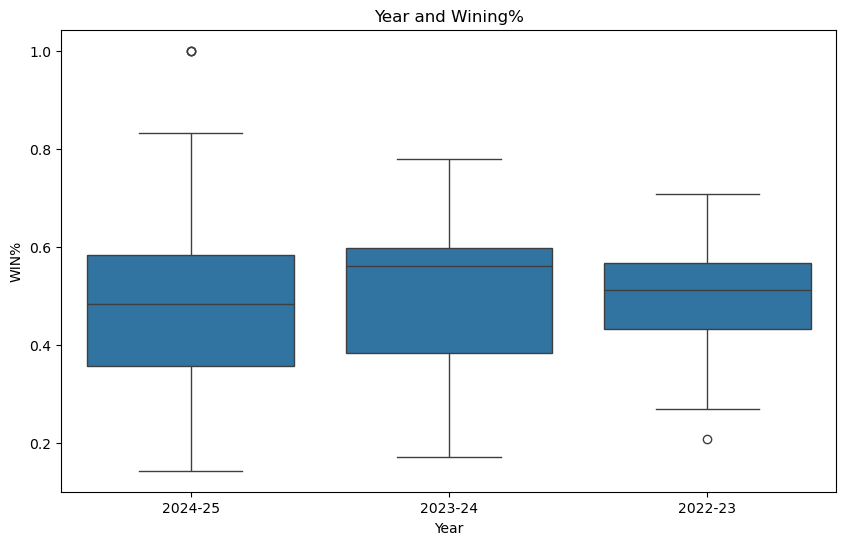

In [108]:

plt.figure(figsize=(10, 6))
sns.boxplot(x='Year', y='WIN%', data=merged_df)
plt.title('Year and Wining%')
plt.xlabel("Year")
plt.ylabel('WIN%')
plt.show()


In [114]:
X = merged_df["Year"]
X = pd.get_dummies(X, columns=['Year'], drop_first=True)

y = merged_df['WIN%']
X = sm.add_constant(X)
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)


model = sm.OLS(y, X).fit()


print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   WIN%   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                 0.0009430
Date:                Sun, 15 Dec 2024   Prob (F-statistic):              0.999
Time:                        13:43:59   Log-Likelihood:                 45.651
No. Observations:                 151   AIC:                            -85.30
Df Residuals:                     148   BIC:                            -76.25
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5000      0.033     15.159      0.0

### Model 1
- let's target Data with no W and L

In [121]:

X = df_train[['PTS', 'FG%', '3P%', 'REB', 'AST', 'TOV', 'STL', 'BLK', "Team"]]

categorical_columns = ['Team']

X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

Y = df_train['WIN%']
X = sm.add_constant(X)

for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)


model = sm.OLS(Y, X)
results = model.fit()

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                   WIN%   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     15.88
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           9.78e-10
Time:                        13:44:54   Log-Likelihood:                 132.94
No. Observations:                  61   AIC:                            -189.9
Df Residuals:                      23   BIC:                            -109.7
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [145]:
df_train

,Team,Year,GP,MIN,PTS,W,L,WIN%,FGM,FGA,...,REB,AST,TOV,STL,BLK,PF,+/-,Top30_num,Salary_x,Salary_y
30,Atlanta Hawks,2023-24,82,48.4,118.3,36,46,0.439,43.0,92.5,...,44.7,26.6,13.5,7.5,4.5,18.6,-2.2,1,40064220,40064220
31,Boston Celtics,2023-24,82,48.4,120.6,64,18,0.780,43.9,90.2,...,46.3,26.9,11.9,6.8,6.6,16.2,11.3,2,36861707,36861707
32,Brooklyn Nets,2023-24,82,48.3,110.4,32,50,0.390,40.7,89.1,...,44.1,25.6,13.1,6.8,5.2,18.5,-2.9,1,37893408,37893408
33,Chicago Bulls,2023-24,82,48.7,112.3,39,43,0.476,42.0,89.5,...,43.8,25.0,12.2,7.8,4.8,18.8,-1.4,1,40064220,40064220
34,Charlotte Hornets,2023-24,82,48.1,106.6,21,61,0.256,40.0,87.0,...,40.3,24.8,13.8,6.9,4.5,18.0,-10.2,0,17000000,17000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,Sacramento Kings,2022-23,82,48.4,120.7,48,34,0.585,43.6,88.2,...,42.5,27.3,13.5,7.0,3.4,19.7,2.6,0,28103550,28103550
147,San Antonio Spurs,2022-23,82,48.4,113.0,22,60,0.268,43.1,92.6,...,43.7,27.2,15.3,7.0,3.9,19.9,-10.0,0,13750000,13750000
148,Toronto Raptors,2022-23,82,48.3,112.9,41,41,0.500,41.9,91.3,...,43.0,23.9,11.7,9.4,5.2,20.0,1.5,1,35448672,35448672
149,Utah Jazz,2022-23,82,48.3,117.1,37,45,0.451,42.5,89.8,...,45.9,26.0,15.4,6.1,5.2,20.5,-0.9,0,16500000,16500000


In [127]:
model1 = LinearRegression()
model1.fit(X, Y)

LinearRegression()

In [129]:
new_df = df_test[['PTS', 'FG%', '3P%', 'REB', 'AST', 'TOV', 'STL', 'BLK', "Team"]]
categorical_columns = ['Team']
new_df = pd.get_dummies(new_df,columns=categorical_columns, drop_first=True)


for col in new_df.columns:
    if new_df[col].dtype == 'bool':

        new_df[col] = new_df[col].astype(int)
new_df = sm.add_constant(new_df)

In [131]:
prediction1 = model1.predict(new_df)
prediction1

array([0.31616574, 1.05661195, 0.235987  , 0.49069191, 0.62073282,
       0.53305618, 0.36123922, 0.79521544, 0.27432965, 0.11753051,
       0.2604631 , 0.430108  , 0.21804007, 0.50011639, 0.47448262,
       0.83271184, 0.22435214, 0.53445926, 0.59551504, 0.60045689,
       0.49234228, 0.27817826, 0.34193283, 0.57751666, 0.51335191,
       0.50749348, 0.64855296, 0.34359467, 0.69564625, 0.21872212,
       0.430108  , 0.60045689, 0.27817826, 0.36123922, 0.31616574,
       1.05661195, 0.53445926, 0.69564625, 0.235987  , 0.83271184,
       0.53305618, 0.49069191, 0.49234228, 0.47448262, 0.51335191,
       0.79521544, 0.62073282, 0.50749348, 0.2604631 , 0.59551504,
       0.64855296, 0.27432965, 0.21804007, 0.50011639, 0.34359467,
       0.57751666, 0.34193283, 0.22435214, 0.21872212, 0.11753051,
       0.430108  , 0.60045689, 0.27817826, 0.36123922, 0.31616574,
       1.05661195, 0.53445926, 0.69564625, 0.235987  , 0.83271184,
       0.53305618, 0.49069191, 0.49234228, 0.47448262, 0.51335

In [137]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


y_true = df_test['WIN%']
y_pred = prediction1
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')


Mean Squared Error (MSE): 0.019335287171913032
Root Mean Squared Error (RMSE): 0.1390513832074785
Mean Absolute Error (MAE): 0.10356552947249563
R-squared (R²): 0.5188123172284276


## Model 2
With Player stats

In [143]:

X = df_train[['PTS', 'FG%', '3P%', 'REB', 'AST', 'TOV', 'STL', 'BLK', "Team", "Top30_num", "Salary"]]

categorical_columns = ['Team']

X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

Y = df_train['WIN%']
X = sm.add_constant(X)


for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)


model = sm.OLS(Y, X)
results = model.fit()

print(results.summary())


KeyError: "['Salary'] not in index"

In [ ]:
# without splitting the training data
model2 = LinearRegression()
model2.fit(X, Y)

In [ ]:
new_df = df_test[['PTS', 'FG%', '3P%', 'REB', 'AST', 'TOV', 'STL', 'BLK', "Team", "Top30_num", "Salary"]]
categorical_columns = ['Team']
new_df = pd.get_dummies(new_df,columns=categorical_columns, drop_first=True)


for col in new_df.columns:
    if new_df[col].dtype == 'bool':

        new_df[col] = new_df[col].astype(int)
new_df = sm.add_constant(new_df)

In [ ]:
prediction2 = model2.predict(new_df)
prediction2

In [ ]:

y_true = df_test['WIN%']
y_pred = prediction2
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')


## Model 3
### with all variables

In [147]:
X = df_train.drop(columns=["WIN%", "Year", "W", "L"])

categorical_columns = ['Team']

X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

Y = df_train['WIN%']
X = sm.add_constant(X)


for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)


model = sm.OLS(Y, X)
results = model.fit()

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                   WIN%   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     35.33
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           2.13e-06
Time:                        13:53:41   Log-Likelihood:                 194.71
No. Observations:                  61   AIC:                            -285.4
Df Residuals:                       9   BIC:                            -175.7
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
GP                

In [ ]:
model3 = LinearRegression()
model3.fit(X, Y)

In [ ]:
new_df = df_test
categorical_columns = ['Team']
new_df = pd.get_dummies(new_df,columns=categorical_columns, drop_first=True)


for col in new_df.columns:
    if new_df[col].dtype == 'bool':

        new_df[col] = new_df[col].astype(int)

new_df = sm.add_constant(new_df)
new_df = new_df.drop(columns=["WIN%", "Year","W","L"])

In [ ]:
prediction3 = model3.predict(new_df)
prediction3

In [ ]:

y_true = df_test['WIN%']  # Actual WIN%
y_pred = prediction3  # Predicted WIN%


mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)


print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')


# Model 4
withot categorical variables team

In [ ]:
X = df_train.drop(columns=["WIN%", "Year", "Team", "W", "L"])


Y = df_train['WIN%']


X = sm.add_constant(X)



model = sm.OLS(Y, X)
results = model.fit()


print(results.summary())


In [ ]:
model4 = LinearRegression()
model4.fit(X, Y)

In [ ]:
new_df = df_test.drop(columns=["WIN%", "Year", "Team", "W", "L"])
new_df = sm.add_constant(new_df)
prediction4 = model4.predict(new_df)
prediction4

In [ ]:

y_true = df_test['WIN%']
y_pred = prediction4

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')


# Model 5
targeted variables without team

In [ ]:
import statsmodels.api as sm
import pandas as pd
X = df_train[['PTS', 'FG%', '3P%', 'REB', 'AST', 'TOV', 'STL', 'BLK', "Top30_num", "Salary"]]


Y = df_train['WIN%']

X = sm.add_constant(X)

for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)


model = sm.OLS(Y, X)
results = model.fit()


print(results.summary())


In [ ]:
new_df = df_test[['PTS', 'FG%', '3P%', 'REB', 'AST', 'TOV', 'STL', 'BLK', "Top30_num", "Salary"]]


for col in new_df.columns:
    if new_df[col].dtype == 'bool':

        new_df[col] = new_df[col].astype(int)

new_df = sm.add_constant(new_df)

In [ ]:
model5 = LinearRegression()
model5.fit(X, Y)
prediction5 = model5.predict(new_df)
prediction5

In [ ]:

y_true = df_test['WIN%']
y_pred = prediction5

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')

## Predict the team with highest WIN%

In [ ]:
predict1_win = df_test["Team"].iloc[np.argmax(prediction1)]
predict2_win = df_test["Team"].iloc[np.argmax(prediction2)]
predict3_win = df_test["Team"].iloc[np.argmax(prediction3)]
predict4_win = df_test["Team"].iloc[np.argmax(prediction4)]
predict5_win = df_test["Team"].iloc[np.argmax(prediction5)]
actual_win = df_test["Team"].iloc[np.argmax(y_true)]
print(f"Predict Model 1: {predict1_win} \n"
   f"Predict Model 2: {predict2_win} \n"
   f"Predict Model 3: {predict3_win} \n"
   f"Predict Model 4: {predict4_win} \n"
   f"Predict Model 5: {predict5_win} \n"
      f"Actual: {actual_win}")

##Random Forest

**clean JSON files**

In [ ]:
import json
import re

def validate_and_clean_json(file_path, output_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        # Remove invalid control characters
        clean_content = re.sub(r'[\x00-\x1F\x7F-\x9F]', '', content)

    try:
        # Attempt to parse the cleaned content
        raw_data = json.loads(clean_content)

        # Save cleaned and validated JSON
        with open(output_path, 'w', encoding='utf-8') as outfile:
            json.dump(raw_data, outfile, indent=4, ensure_ascii=False)
        print(f"Cleaned and validated file saved to {output_path}")
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON in {file_path}: {e}.")
        # Save the cleaned but invalid JSON for manual inspection
        with open(output_path, 'w', encoding='utf-8') as outfile:
            outfile.write(clean_content)
        print(f"Partially cleaned file saved to {output_path} for inspection.")

# Apply to all files
file_paths = [
    '/content/team_statistic(2020-2021).json',
    '/content/team_statistics(2021-2022).json',
    '/content/team_statistics(2022-2023).json',
    '/content/team_statistics(2023-2024)json.json',
    '/content/team_statistics(2024-2025).json'
]

output_paths = [
    '/content/team_statistic_cleaned(2020-2021).json',
    '/content/team_statistic_cleaned(2021-2022).json',
    '/content/team_statistic_cleaned(2022-2023).json',
    '/content/team_statistic_cleaned(2023-2024)json.json',
    '/content/team_statistic_cleaned(2024-2025).json'
]

for input_path, output_path in zip(file_paths, output_paths):
    validate_and_clean_json(input_path, output_path)


In [ ]:
import pandas as pd
file_path = '/content/combined_team_player_data.xlsm'
df = pd.read_excel(file_path)
print(df.head(5))


**Random Forest - Model 1 (including all variables)**


In [ ]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load and preprocess JSON data
def load_and_process_data(file_paths, features):
    all_data = []
    for path in file_paths:
        with open(path, 'r', encoding='utf-8') as file:
            raw_data = json.load(file)

            # Ensure the JSON is a list of dictionaries
            if isinstance(raw_data, list):
                processed_data = []
                for team in raw_data:
                    team_name = team.get('Team', 'Unknown Team')
                    stats = team.get('Statistics', {})

                    # Extract relevant stats
                    row = {**{'Team': team_name}, **{key: stats.get(key, None) for key in features}}
                    processed_data.append(row)

                # Convert processed data to DataFrame and append
                df = pd.DataFrame(processed_data)
                all_data.append(df)
            else:
                print(f"Unexpected structure in file {path}")

    # Combine all DataFrames
    combined_data = pd.concat(all_data, ignore_index=True)
    return combined_data

# Step 2: Define file paths and features
file_paths = [
    "/content/team_statistic_cleaned(2020-2021).json",
    "/content/team_statistic_cleaned(2021-2022).json",
    "/content/team_statistic_cleaned(2022-2023).json",
    "/content/team_statistic_cleaned(2023-2024)json.json"
]

# Features and target
features = ['WIN%', 'PTS', 'FG%', '3P%', 'REB', 'AST', 'TOV', 'STL', 'BLK']
target = 'W'  # Predict wins

# Step 3: Load and process data
data = load_and_process_data(file_paths, features + [target])

# Convert features to numeric
for col in features:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data[target] = pd.to_numeric(data[target], errors='coerce')

# Drop rows with missing values
data = data.dropna()

# Prepare training and test datasets
X = data[features]
y = data[target].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Plot Feature Importances
importances = rf_model.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importances")
plt.show()

# Step 6: Predict for 2024-2025 season
data_2024_2025 = load_and_process_data(["/content/team_statistic_cleaned(2024-2025).json"], features)

# Convert features to numeric
data_2024_2025[features] = data_2024_2025[features].astype(float)

# Predict wins
predictions_2024_2025 = rf_model.predict(data_2024_2025[features])
data_2024_2025['Predicted_Win'] = predictions_2024_2025

# Save predictions to CSV
data_2024_2025.to_csv("predictions_2024_2025.csv", index=False)
print("Predictions saved to predictions_2024_2025.csv")


In [ ]:
# Print predictions for 2024-2025 season
print("Predictions for 2024-2025 season:")
print(data_2024_2025[['Team', 'Predicted_Win']])
# predicted win = predicted number of games won by each team in the 2024-2025 season

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract feature importances from the trained model
feature_importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
features_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


**Random Forest - Model 2 (eliminate certain features)**


In [ ]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load and preprocess JSON data
def load_and_process_data(file_paths, features):
    all_data = []
    for path in file_paths:
        with open(path, 'r', encoding='utf-8') as file:
            raw_data = json.load(file)

            # Ensure the JSON is a list of dictionaries
            if isinstance(raw_data, list):
                processed_data = []
                for team in raw_data:
                    team_name = team.get('Team', 'Unknown Team')
                    stats = team.get('Statistics', {})

                    # Extract relevant stats
                    row = {**{'Team': team_name}, **{key: stats.get(key, None) for key in features}}
                    processed_data.append(row)

                # Convert processed data to DataFrame and append
                df = pd.DataFrame(processed_data)
                all_data.append(df)
            else:
                print(f"Unexpected structure in file {path}")

    # Combine all DataFrames
    combined_data = pd.concat(all_data, ignore_index=True)
    return combined_data

# Step 2: Define file paths and features
file_paths = [
    "/content/team_statistic_cleaned(2020-2021).json",
    "/content/team_statistic_cleaned(2021-2022).json",
    "/content/team_statistic_cleaned(2022-2023).json",
    "/content/team_statistic_cleaned(2023-2024)json.json"
]

# Top 3 features based on importance
features = ['WIN%', 'TOV', '3P%']
target = 'W'  # Predict wins

# Step 3: Load and process data
data = load_and_process_data(file_paths, features + [target])

# Convert features to numeric
for col in features:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data[target] = pd.to_numeric(data[target], errors='coerce')

# Drop rows with missing values
data = data.dropna()

# Prepare training and test datasets
X = data[features]
y = data[target].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Plot Feature Importances
importances = rf_model.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importances")
plt.show()

# Step 6: Predict for 2024-2025 season
data_2024_2025 = load_and_process_data(["/content/team_statistic_cleaned(2024-2025).json"], features)

# Convert features to numeric
data_2024_2025[features] = data_2024_2025[features].astype(float)

# Predict wins
predictions_2024_2025 = rf_model.predict(data_2024_2025[features])
data_2024_2025['Predicted_Win'] = predictions_2024_2025

# Save predictions to CSV
data_2024_2025.to_csv("predictions_2024_2025.csv", index=False)
print("Predictions saved to predictions_2024_2025.csv")


In [ ]:
# Step 6: Predict for 2024-2025 season
data_2024_2025 = load_and_process_data(["/content/team_statistic_cleaned(2024-2025).json"], features)

# Convert features to numeric
data_2024_2025[features] = data_2024_2025[features].astype(float)

# Predict wins
predictions_2024_2025 = rf_model.predict(data_2024_2025[features])
data_2024_2025['Predicted_Win'] = predictions_2024_2025

# Print predictions
print("Predictions for 2024-2025 season:")
print(data_2024_2025[['Team', 'Predicted_Win']])

# Save predictions to CSV
data_2024_2025.to_csv("predictions_2024_2025.csv", index=False)
print("Predictions saved to predictions_2024_2025.csv")


**Random Forest - Model 3 (add player's data)**

In [ ]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load Data
def load_and_process_data(file_paths, salary_data, top30_data, features):
    all_data = []
    for path in file_paths:
        with open(path, 'r', encoding='utf-8') as file:
            raw_data = json.load(file)

            if isinstance(raw_data, list):
                processed_data = []
                for team in raw_data:
                    team_name = team.get('Team', 'Unknown Team')
                    stats = team.get('Statistics', {})

                    row = {**{'Team': team_name}, **{key: stats.get(key, None) for key in features}}
                    row['Highest_Paid_Player_Salary'] = salary_data.get(team_name, 0)
                    row['Top30_num'] = top30_data.get(team_name, 0)

                    processed_data.append(row)

                df = pd.DataFrame(processed_data)
                all_data.append(df)

    combined_data = pd.concat(all_data, ignore_index=True)
    return combined_data

# Load Salary Data
highest_salaries = pd.read_csv('/content/highest_salary_players.csv')
highest_salary_dict = dict(zip(highest_salaries['Team'], highest_salaries['Salary']))

with open('/content/Top30.json', 'r') as top30_file:
    top30_data = json.load(top30_file)
top30_dict = {item['Team']: item['Top30_num'] for item in top30_data}

# File paths and features
file_paths = [
    "/content/team_statistic_cleaned(2020-2021).json",
    "/content/team_statistic_cleaned(2021-2022).json",
    "/content/team_statistic_cleaned(2022-2023).json",
    "/content/team_statistic_cleaned(2023-2024)json.json"
]

features = ['WIN%', '3P%', 'TOV', 'Highest_Paid_Player_Salary', 'Top30_num']
target = 'W'

# Load and Process Data
data = load_and_process_data(file_paths, highest_salary_dict, top30_dict, features + [target])
for col in features:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data[target] = pd.to_numeric(data[target], errors='coerce')
data = data.dropna()

X = data[features]
y = data[target].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Random Forest with Hyperparameter Tuning
param_grid = {'n_estimators': [50, 100], 'max_depth': [5, 10]}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)
rf_model = grid_search.best_estimator_

# Evaluate
y_pred = rf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature Importances
importances = rf_model.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importances")
plt.show()


In [ ]:
# Step 1: Predict for 2024-2025 Season
data_2024_2025 = load_and_process_data(
    ["/content/team_statistic_cleaned(2024-2025).json"],
    highest_salary_dict,
    top30_dict,
    features
)

# Convert features to numeric
for col in features:
    data_2024_2025[col] = pd.to_numeric(data_2024_2025[col], errors='coerce')

# Scale features using the same scaler as before
X_2024_2025 = scaler.transform(data_2024_2025[features])

# Predict wins
data_2024_2025['Predicted_Win'] = rf_model.predict(X_2024_2025)

# Step 2: Aggregate Predicted Wins per Team
team_wins = data_2024_2025.groupby('Team')['Predicted_Win'].sum().reset_index()
team_wins.rename(columns={'Predicted_Win': 'Total_Predicted_Wins'}, inplace=True)

# Step 3: Sort Teams by Predicted Wins
team_wins_sorted = team_wins.sort_values(by='Total_Predicted_Wins', ascending=False)

# Step 4: Visualize Predicted Wins
plt.figure(figsize=(12, 8))
sns.barplot(data=team_wins_sorted, x='Total_Predicted_Wins', y='Team', palette="coolwarm")
plt.title('Predicted Wins per Team for 2024-2025 Season', fontsize=16)
plt.xlabel('Total Predicted Wins', fontsize=14)
plt.ylabel('Team', fontsize=14)
plt.tight_layout()
plt.show()


**Random Forest - Model 4: We normalized or standardized features such as Highest_Paid_Player_Salary and Top30_num and created a new feature, Turnover_to_Points_Ratio, by transforming the TOV variable using the formula: TOV / PTS.**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the combined dataset
file_path = "/content/combined_team_player_data.xlsm"  # Update the path
data = pd.read_excel(file_path)

# Features and target
features = ['WIN%', 'TOV', '3P%', 'STL', 'Highest_Paid_Player_Salary', 'Number_of_Top30_Players']
target = 'W'  # Assuming 'W' represents wins

# Create Turnover_to_Points_Ratio
data['Turnover_to_Points_Ratio'] = data['TOV'] / data['WIN%']
features.append('Turnover_to_Points_Ratio')

# Normalize salary-related features
scaler = MinMaxScaler()
data[['Highest_Paid_Player_Salary', 'Number_of_Top30_Players']] = scaler.fit_transform(
    data[['Highest_Paid_Player_Salary', 'Number_of_Top30_Players']]
)

# Convert features to numeric
for col in features:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data[target] = pd.to_numeric(data[target], errors='coerce')

# Drop rows with missing values
data = data.dropna()

# Separate data for 2024-2025 prediction
if 'Season' in data.columns:
    training_data = data[data['Season'] != 2024]
    prediction_data = data[data['Season'] == 2024]
else:
    training_data = data[:-30]  # Adjust logic based on your data
    prediction_data = data[-30:]  # Adjust logic based on your data

# Split training and test data
X_train = training_data[features]
y_train = training_data[target].astype(int)

X_test = prediction_data[features]
y_test = prediction_data[target].astype(int) if target in prediction_data.columns else None

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model if test data is available
if y_test is not None:
    y_pred = rf_model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Plot Feature Importances
importances = rf_model.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importances")
plt.show()

# Make predictions for 2024-2025
predictions_2024_2025 = rf_model.predict(X_test)
prediction_data['Predicted_Win'] = predictions_2024_2025

# Aggregate predictions by team for the number of predicted wins
team_wins = prediction_data.groupby('Team')['Predicted_Win'].sum()

# Save predictions to CSV
prediction_data.to_csv("predictions_2024_2025.csv", index=False)
print("Predictions saved to predictions_2024_2025.csv")

# Print predictions
print("Predicted number of wins per team for 2024-2025:")
print(team_wins)


# **Generic Equation with weights**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
games_df = pd.read_csv('games.csv')
games_df.describe()

In [ ]:
def calculate_team_stats(team_id, season):
    home_games = games_df[(games_df['TEAM_ID_home'] == team_id) & (games_df['SEASON'] == season)]
    total_games = len(home_games)
    wins = len(home_games[home_games['HOME_TEAM_WINS'] == 1])

    stats = {
        'WIN%': wins / total_games,
        'PTS': home_games['PTS_home'].mean(),
        'FG%': home_games['FG_PCT_home'].mean(),
        'FT%': home_games['FT_PCT_home'].mean(),
        '3P%': home_games['FG3_PCT_home'].mean(),
        'AST': home_games['AST_home'].mean(),
        'REB': home_games['REB_home'].mean()
    }

    return pd.Series(stats)

In [ ]:
def calculate_team_stats(team_id, season):
    home_games = games_df[(games_df['TEAM_ID_home'] == team_id) & (games_df['SEASON'] == season)]
    total_games = len(home_games)
    wins = len(home_games[home_games['HOME_TEAM_WINS'] == 1])

    stats = {
        'WIN%': wins / total_games,
        'PTS': home_games['PTS_home'].mean(),
        'FG%': home_games['FG_PCT_home'].mean(),
        'FT%': home_games['FT_PCT_home'].mean(),
        '3P%': home_games['FG3_PCT_home'].mean(),
        'AST': home_games['AST_home'].mean(),
        'REB': home_games['REB_home'].mean()
    }

    return pd.Series(stats)

In [ ]:
def prepare_data(season):
    all_games = games_df[games_df['SEASON'] == season]

    X = []
    y = []

    for _, game in all_games.iterrows():
        home_stats = calculate_team_stats(game['TEAM_ID_home'], season)
        X.append(home_stats)
        y.append(game['HOME_TEAM_WINS'])

    return pd.DataFrame(X), pd.Series(y)

In [ ]:
def calculate_weights(X_train, y_train):
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train)

    feature_names = X_train.columns
    coefficients = model.coef_[0]

    weights = dict(zip(feature_names, coefficients))
    total = sum(abs(w) for w in weights.values())
    weights = {k: v/total for k, v in weights.items()}

    return weights, model, scaler

In [ ]:
if __name__ == "__main__":
    season = 2022
    X, y = prepare_data(season)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    calculated_weights, model, scaler = calculate_weights(X_train, y_train)

    print("Calculated weights:")
    for feature, weight in calculated_weights.items():
        print(f"{feature}: {weight:.4f}")

    # Make predictions on the test set
    X_test_scaled = scaler.transform(X_test)
    y_pred = model.predict(X_test_scaled)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nModel Accuracy: {accuracy:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

**STEP 3: Function which uses two teams actually values to predict the probability to win**

---



In [ ]:
def predict_game_outcome(team1_stats, team2_stats, model, scaler):
    # Combine stats into a single DataFrame
    combined_stats = pd.DataFrame([team1_stats, team2_stats])

    # Scale the features
    scaled_stats = scaler.transform(combined_stats)

    # Get probabilities for each team
    probabilities = model.predict_proba(scaled_stats)

    # Extract win probabilities
    team1_win_prob = probabilities[0][1]
    team2_win_prob = probabilities[1][1]

    return team1_win_prob, team2_win_prob

In [ ]:
team1_stats = {
        'WIN%': 0.750,
        'PTS': 112.5,
        'FG%': 0.480,
        'FT%': 0.820,
        '3P%': 0.380,
        'AST': 25.5,
        'REB': 44.0
    }

team2_stats = {
        'WIN%': 0.650,
        'PTS': 108.0,
        'FG%': 0.460,
        'FT%': 0.780,
        '3P%': 0.360,
        'AST': 23.0,
        'REB': 42.5
    }

team1_prob, team2_prob = predict_game_outcome(team1_stats, team2_stats, model, scaler)

In [ ]:
# Team statistics for the Boston Celtics and Denver Nuggets
celtics_stats = {
    'WIN%': 0.818,
    'PTS': 120.2,
    'FG%': 0.477,
    'FT%': 0.820,
    '3P%': 0.355,
    'AST': 23.9,
    'REB': 43.5,
}

nuggets_stats = {
    'WIN%': 0.571,
    'PTS': 118.3,
    'FG%': 0.484,
    'FT%': 0.780,
    '3P%': 0.381,
    'AST': 28.7,
    'REB': 47.3,

}

celtics_prob, nuggets_prob = predict_game_outcome(celtics_stats, nuggets_stats, model, scaler)

In [ ]:
print(f"\nPrediction for the example game:")
print(f"Boston Celtics win probability: {celtics_prob:.2%}")
print(f"Denver Nuggets win probability: {nuggets_prob:.2%}")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Function to scrape team stats (simulated for this example)
def get_team_stats(team_id):
    if team_id == 1610612738:  # Boston Celtics
        return pd.DataFrame({
            'Team': ['Celtics'],
            'W': [9], 'L': [2], 'WIN%': [0.818],
            'PTS': [120.2], 'FG%': [47.7], '3P%': [35.5],
            'REB': [43.5], 'AST': [23.9], 'TOV': [13.5],
            'STL': [7.5], 'BLK': [6.5]
        })
    elif team_id == 1610612743:  # Denver Nuggets
        return pd.DataFrame({
            'Team': ['Nuggets'],
            'W': [4], 'L': [3], 'WIN%': [0.571],
            'PTS': [118.3], 'FG%': [48.4], '3P%': [38.1],
            'REB': [47.3], 'AST': [28.7], 'TOV': [14.3],
            'STL': [8.6], 'BLK': [5.0]
        })

# Get statistics for both teams
celtics_stats = get_team_stats(1610612738)
nuggets_stats = get_team_stats(1610612743)

# Combine statistics into a single DataFrame for comparison
comparison_df = pd.concat([celtics_stats, nuggets_stats]).reset_index(drop=True)

# Set the position of bars on x-axis
bar_width = 0.35
x = np.arange(len(comparison_df.columns) - 1)  # Exclude the first column (Team)

# Create bar plots for each team
plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - bar_width/2, comparison_df.iloc[0, 1:], bar_width, label='Celtics', color='blue')
bars2 = plt.bar(x + bar_width/2, comparison_df.iloc[1, 1:], bar_width, label='Nuggets', color='orange')

# Adding labels and title
plt.xlabel('Statistics')
plt.ylabel('Values')
plt.title('Comparison of Team Statistics: Celtics vs Nuggets')
plt.xticks(x, comparison_df.columns[1:])  # Use statistics names as x-ticks
plt.legend()

# Adding value labels on top of bars
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the feature weights
feature_weights = {
    'Feature': ['WIN%', 'PTS', 'FG%', 'FT%', '3P%', 'AST', 'REB'],
    'Weight': [0.5986, 0.0300, -0.0749, 0.0596, 0.1353, -0.0474, 0.0541]
}

# Create a DataFrame
weights_df = pd.DataFrame(feature_weights)

# Sort values by weight for better visualization
weights_df = weights_df.sort_values(by='Weight', ascending=False)

# Plotting the feature importance
plt.figure(figsize=(10, 6))
plt.bar(weights_df['Feature'], weights_df['Weight'], color=['blue' if w >= 0 else 'red' for w in weights_df['Weight']])
plt.title('Feature Importance for Win Probability Prediction')
plt.xlabel('Features')
plt.ylabel('Calculated Weights')
plt.axhline(0, color='black', linewidth=0.8)  # Add a line at y=0 for reference
plt.grid(axis='y')

# Adding value labels on top of bars
for index, value in enumerate(weights_df['Weight']):
    plt.text(index, value + 0.01 if value >= 0 else value - 0.05, f"{value:.4f}", ha='center')

plt.tight_layout()
plt.show()